<h1>Konfiguracja</h1>

<h3>Instalacja bibliotek</h3>

In [3]:
!pip install moviepy
!pip install mediapipe
!pip install tensorflow tensorflow-gpu opencv-python mediapipe sklearn matplotlib

<h3>Funkcje pomocnicze</h3>

Importowanie i konfiguracja

In [3]:
import numpy as np
import math
import mediapipe as mp

mp_drawing = mp.solutions.drawing_utils
mp_holistic = mp.solutions.holistic

Filtrowanie punktów kluczowych pozy ciała

In [4]:
def filter_pose_landmarks(pose):
    indexes_to_remove = [23,24,25,26,27,28,29,30,31,32]
    filtered = np.delete(pose,indexes_to_remove)
    return filtered

Ekstrakcja znormalizowanych punktów kluczowych

In [5]:
def extract_keypoints_with_normalization(results):
    smallestX = 1
    biggestX = 0
    smallestY = 1
    biggestY = 0
    smallestZ = 1
    biggestZ = 0

    pose = np.array([[res.x, res.y, res.z] for res in filter_pose_landmarks(results.pose_landmarks.landmark)] if results.pose_landmarks else [[0,0,0] for i in range(23)]) 
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark] if results.left_hand_landmarks else [[0,0,0] for i in range(21)]) 
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark] if results.right_hand_landmarks else [[0,0,0] for i in range(21)]) 
    concatenated = np.concatenate([pose, lh, rh])
    for landmark in concatenated:
        newX = landmark[0]
        newY = landmark[1]
        newZ = landmark[2]
        if(smallestX>newX):
            smallestX = newX 
        if(biggestX<newX):
            biggestX = newX 
        if(smallestY>newY):
            smallestY = newY 
        if(biggestY<newY):
            biggestY = newY 
        if(smallestZ>newZ):
            smallestZ = newZ 
        if(biggestZ<newZ):
            biggestZ = newZ 
        
    normalizedLandmarks = []
    for landmark in concatenated:
        x_norm = (landmark[0]-smallestX)/(biggestX-smallestX)
        y_norm = (landmark[1]-smallestY)/(biggestY-smallestY)
        z_norm = (landmark[2]-smallestZ)/(biggestZ-smallestZ)
        if math.isnan(x_norm):
            x_norm = 0.0
        if math.isnan(y_norm):
            y_norm = 0.0
        if math.isnan(z_norm):
            z_norm = 0.0
        normalizedLandmarks.append([x_norm,y_norm,z_norm])
    return np.array(normalizedLandmarks).flatten()

Detekcja punktów kluczowych

In [6]:
def mediapipe_video_detection(image,model):
    results = model.process(image)
    return image,results

Rysowanie rozpoznanych punktów kluczowych

In [7]:
def draw_styled_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION, 
                             mp_drawing.DrawingSpec(color=(70,70,200), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=1, circle_radius=1)
                             ) 
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(170,170,170), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(70,200,70), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=2, circle_radius=2)
                             ) 
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(200,70,70), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(70,70,70), thickness=2, circle_radius=2)
                             ) 

<h1>Zbieranie nagrań</h1>

Importowanie

In [8]:
from moviepy.editor import *
import numpy as np
import cv2
import os

Stałe i zmienne

In [16]:

DATA_PATH = os.path.join('videos/PJM') 
ACTIONS_21 = ['dziękuję','proszę','przepraszam','od','jest','który','ja','gdzie','ty','imię','nazwisko','jeśli','ile','duży','mało','dobrze','źle','wiem','dom','mieszkać','kocham']
TRICKY=['do','mam']
ALL_ACTIONS = ACTIONS_21

no_sequences = 30
sequence_length = 45

Tworzenie folderów dla znaków dynamicznych

In [18]:
for action in ALL_ACTIONS: 
    try: 
        os.makedirs(os.path.join(DATA_PATH,'fps30', action))
        os.makedirs(os.path.join(DATA_PATH,'fps15', action))
    except:
        pass

Zbieranie sekwencji

In [21]:
actions = np.array(['jest'])

cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FPS, 30)
cv2.waitKey(3000)
for action in actions:
    for sequence in range(1,no_sequences+1):
        recorded_frames = []
        for frame_num in range(sequence_length+1):
            ret, image = cap.read()
            
            if frame_num == 0: 
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECT IN: 3', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (35, 184, 75), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECT IN: 2', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (35, 184, 75), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECT IN: 1', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (35, 184, 75), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'GET READY', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (61, 223, 235), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(500)
            else: 
                cv2.rectangle(image, (0,440), (640, 480), (20, 20, 20), -1)
                cv2.putText(image, 'COLLECTING NOW', (20,470),cv2.FONT_HERSHEY_TRIPLEX, 1, (25, 29, 250), 1, cv2.LINE_AA)
                cv2.putText(image, 'Sentence: {} , Sample: {}'.format(action, sequence), (330,465), cv2.FONT_HERSHEY_TRIPLEX, 0.5, (250, 250, 250), 1, cv2.LINE_AA)
                cv2.imshow('OpenCV Feed', image)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                recorded_frames.append(image)  
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
        save_path_30 = os.path.join(DATA_PATH,'fps30', action,str(sequence)+'.mp4')
        save_path_15 = os.path.join(DATA_PATH,'fps15', action,str(sequence)+'.mp4')
        clip30 = ImageSequenceClip(recorded_frames, fps=30)
        clip30.write_videofile(save_path_30, fps=30,codec="libx264")
        clip15 = ImageSequenceClip(recorded_frames, fps=30)
        clip15.write_videofile(save_path_15, fps=15,codec="libx264")
        
                    
cap.release()
cv2.destroyAllWindows()

<h1>Konwersja video na mediapipe keypoints<h1>

Stałe i zmienne

In [22]:
KEYPOINTS_DATA_PATH = "dynamicKeypoints/PJM"
FRAMESNO='fps15'

Tworzenie folderów dla punkty kluczowe

In [23]:
for action in ALL_ACTIONS: 
    for sequence in range(1,no_sequences+1):
        try: 
            os.makedirs(os.path.join(KEYPOINTS_DATA_PATH,'fps15', action, str(sequence)))
            os.makedirs(os.path.join(KEYPOINTS_DATA_PATH,'fps30', action, str(sequence)))
        except:
            pass

Konwersja nagrań na punkty kluczowe

In [24]:

from moviepy.editor import *

with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    for action in ALL_ACTIONS:
        for sequence in range(1,no_sequences+1):
            clip = VideoFileClip(os.path.join(DATA_PATH,FRAMESNO,action,str(sequence)+".mp4"))
            frames = clip.iter_frames()
            clip_fps = clip.fps
            counter = 0
            for frame in frames:
                image, results = mediapipe_video_detection(frame, holistic)
                keypoints = extract_keypoints_with_normalization(results)
                npy_path = os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO,action,str(sequence),str(counter))
                np.save(npy_path, keypoints)
                counter += 1
     

<h1>Szkolenie modelu</h1>

Importowanie

In [25]:
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, SimpleRNN
from tensorflow.keras.callbacks import TensorBoard

Stałe i zmienne

In [64]:
SEQUENCELENGTH_15FPS = 23

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

label_map = {label:num for num, label in enumerate(ALL_ACTIONS)}
print(label_map)

{'dziękuję': 0, 'proszę': 1, 'przepraszam': 2, 'od': 3, 'jest': 4, 'który': 5, 'ja': 6, 'gdzie': 7, 'ty': 8, 'imię': 9, 'nazwisko': 10, 'jeśli': 11, 'ile': 12, 'duży': 13, 'mało': 14, 'dobrze': 15, 'źle': 16, 'wiem': 17, 'dom': 18, 'mieszkać': 19, 'kocham': 20}


Wczytanie danych z tablic

In [28]:
sequences, labels = [], []
for action in ALL_ACTIONS:
    for sequence in np.array(os.listdir(os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO, action))).astype(int):
        window = []
        for frame_num in range(SEQUENCELENGTH_15FPS):
            res = np.load(os.path.join(KEYPOINTS_DATA_PATH,FRAMESNO, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

Przygotowanie i podział na zbiory 

In [131]:
X = np.array(sequences)
y = to_categorical(labels).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1)

print("x shape: ")
print(X.shape)
print("y shape: ")
print(y.shape)
print("x_test shape: ")
print(X_test.shape)
print("y_test shape: ")
print(y_test.shape)

x shape: 
(630, 23, 195)
y shape: 
(630, 21)
x_test shape: 
(63, 23, 195)
y_test shape: 
(63, 21)


<h3>Inicjalizacja i szkolenie modelu</h3>

Szkolenie LSTM

In [ ]:
model2 = Sequential()
model2.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(23,195)))
model2.add(LSTM(64, return_sequences=False, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.fit(X_train, y_train, epochs=300, callbacks=[tb_callback],validation_split=0.1)

Szkolenie RNN

In [ ]:
model2 = Sequential()
model2.add(SimpleRNN(64, return_sequences=True, activation='relu', input_shape=(23,195)))
model2.add(SimpleRNN(64, return_sequences=False, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.fit(X_train, y_train, epochs=300, callbacks=[tb_callback],validation_split=0.1)

Szkolenie GRU

In [ ]:
model2 = Sequential()
model2.add(GRU(128, return_sequences=True, activation='relu', input_shape=(23,195)))
model2.add(GRU(128, return_sequences=False, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(64, activation='relu'))
model2.add(Dense(np.array(ALL_ACTIONS).shape[0], activation='softmax'))
model2.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model2.fit(X_train, y_train, epochs=350, callbacks=[tb_callback],validation_split=0.1)

Zapisanie modelu i prezentacja podsumowania

In [33]:
model2.save('models/PJM_21_full_dynamic_lstm_v5.h5')
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 23, 64)            66560     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 21)                1365      
                                                                 
Total params: 109,269
Trainable params: 109,269
Non-trainable params: 0
_________________________________________________________________


Wczytywanie modelu

In [34]:
from keras.models import load_model

In [35]:
model2 = load_model('models/PJM_21_full_dynamic_lstm_v5.h5')

<h1> Dokładność i macierze błędów </h1>

Importowanie z bibliotek

In [47]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, confusion_matrix

Obliczanie wyników

In [137]:
yhat = model2.predict(X_test)
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()
mtrx = multilabel_confusion_matrix(ytrue, yhat)
confusion_mtrx = confusion_matrix(ytrue,yhat)
accuracy = accuracy_score(ytrue, yhat)

Dokładność modelu matematycznego

In [ ]:
print("Model accuracy: ")
print(accuracy)

Model accuracy: 
0.8417721518987342


Macierz błędów dla wszystkich statycznych znaków

<Axes: >

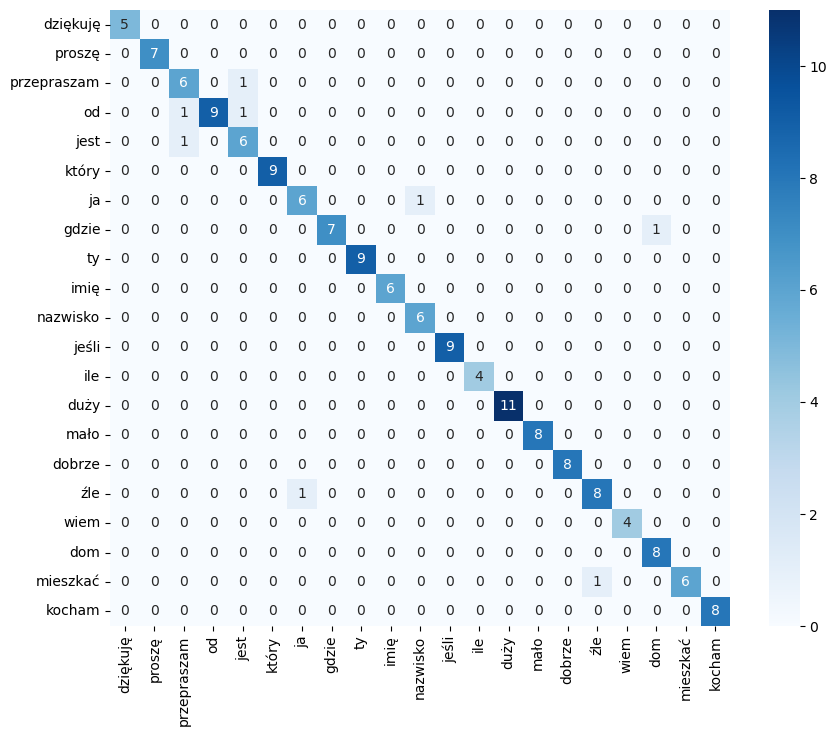

In [ ]:
array = confusion_mtrx
df_cm = pd.DataFrame(array, index = [i for i in ALL_ACTIONS],
                  columns = [i for i in ALL_ACTIONS])
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,cmap=plt.cm.Blues)